/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/rachitkumarsingh/Library/

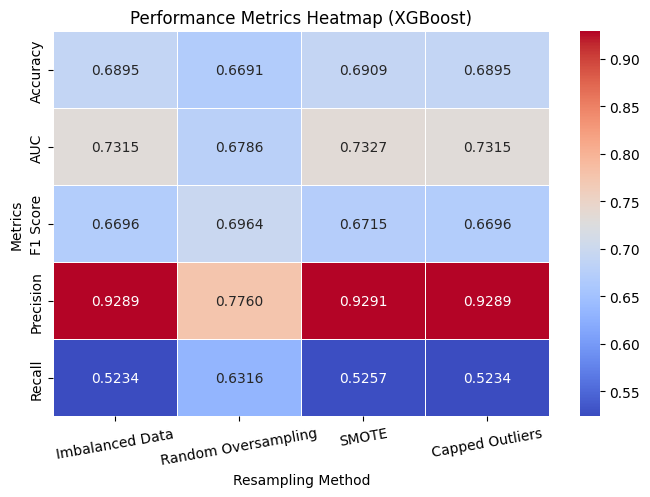

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from pandas import SparseDtype


df = pd.read_csv('../Data/Encoded_data.csv')
X = df.drop('Reached', axis=1)
y = df['Reached']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a dictionary to store the results
results = {}

# Define a list of resampling methods
resampling_methods = ["Imbalanced Data", "Random Oversampling", "SMOTE", "Capped Outliers"]

# Loop through each resampling method
for method in resampling_methods:
    if method == "Imbalanced Data":
        X_resampled = X_train
        y_resampled = y_train
    elif method == "Random Oversampling":
        ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    elif method == "SMOTE":
        smote = SMOTE(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    elif method == "Capped Outliers":
        X_resampled = X_train.copy()
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)  # Convert to DataFrame
        for col in X_resampled.columns:
            std_dev = X_resampled[col].std()
            X_resampled[col] = np.where(X_resampled[col] > 3 * std_dev, 3 * std_dev, X_resampled[col])
        y_resampled = y_train

    # Hyperparameter tuning for XGBoost
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 2, 3],
    }
    xgb = XGBClassifier(random_state=42)
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_resampled, y_resampled)
    best_xgb = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_xgb.predict(X_test)

    # Calculate evaluation metrics for XGBoost
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Store the results for XGBoost
    results[method] = {
        "Accuracy": accuracy,
        "AUC": auc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Plot a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title("Performance Metrics Heatmap (XGBoost)")
plt.xlabel("Resampling Method")
plt.ylabel("Metrics")
plt.xticks(rotation = 10)
plt.show()
